# Popular Hashtags Over Time
**Sophia and Victoria**

In this notebook, we're going to be exploring how to visualize information about the hashtags people use in tweets! In this notebook, we'll be using a subset of the data!

# Importing everthing!
Let's get ready to do some cool data things!

In [39]:
% matplotlib inline
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime, date, timedelta


import cartopy.crs as ccrs
from ipywidgets import widgets
import matplotlib.cm as cm

from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile


# Reading in Data
Here, we're using a function that we've developed to read in the data, a certain number of lines at a time. This uses a file of cleaned tweets that can be found...

In [2]:
def ReadToDf(linesAtATime,filepath, max=-1):
    start = time.time()
    df = pd.DataFrame()
    i = 0
    data = [] 
    
    #Open and read in the file
    with open(filepath) as cleanedTweets:
        for tweet in cleanedTweets:
            i += 1
            jsonline = json.loads(tweet)
            data.append(jsonline)
            #aggregate once we've read in the appropriate number of liens
            if (i % linesAtATime == 0):
                print "number of tweets parsed: ", i
                print "total time elapsed: ", time.time() - start
                df = df.append(pd.DataFrame(data=data))
                #reset the data
                data = []
        #Allow us to handle the last few tweets, and to truncate the data if we just want to run unit tests
            if (max > 0 and i >= max):
                break
        df = pd.DataFrame(data=data).append(df)
    #return the aggregation
    return df

In [3]:
shooting_df = ReadToDf(100000, 'data/cleanedShootingTweets.json', 200000)

number of tweets parsed:  100000
total time elapsed:  1.75667119026
number of tweets parsed:  200000
total time elapsed:  4.05197715759


In [5]:
shooting_df.head(10)

,coordinates_x,coordinates_y,created_at,entities_hashtags_text,entities_user_mentions_id_str,entities_user_mentions_screen_name,id_str,retweet_count,retweeted_status_id_str,user_id_str,user_screen_name,user_verified
0,NaN,NaN,Sun Aug 17 17:52:55 +0000 2014,[Ferguson],[],[],501064141332029440,3,None,851336634,20mUsa,True
1,NaN,NaN,Sun Aug 17 17:53:02 +0000 2014,[Ferguson],[295988417],[NerdyNegress],501064171707170816,10,501064110696857600,53158947,MzDivah67,False
2,NaN,NaN,Sun Aug 17 17:53:04 +0000 2014,[Ferguson],[295988417],[NerdyNegress],501064180468682752,10,501064110696857600,619587350,BrookLyn1825,False
3,NaN,NaN,Sun Aug 17 17:53:06 +0000 2014,[],[],[],501064188211765249,0,None,374346913,I_Mpower,False
4,NaN,NaN,Sun Aug 17 17:53:07 +0000 2014,[USNews],[],[],501064194309906436,0,None,2272978051,Vorarlberg1,False
5,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,[Ferguson],[90296594],[Thatindianbruh],501064196642340864,10479,501051914218668032,1458086762,rachel_palomera,False
6,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,"[Ferguson, MikeBrown]",[18989941],[BgRs],501064196931330049,228,501017032486178818,278298244,bookishshelly,False
7,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,[],[],[],501064197396914176,0,None,1112443196,deegerwiilen,False
8,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,"[Ferguson, tcot, uniteblue, teaparty, gop]",[],[],501064197632167936,134,501062167303450626,21811025,mmaureen7,False
9,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,"[Ferguson, CrimeButNoTime]",[935015863],[bryancrumpler],501064198009655296,5493,501011628448841728,2743004644,collettehodson,False


## Cleaning Data
This is where we're going to clean data that we've read in. The only cleaning that we need to do is that we need to convert the "created_at" column to a datetime object. The rest of the cleaning data is done in the script `development_scripts/clean_json_data.py`. 

In [6]:
def recodeData (dataframe):
    # Creating a parseable dataset    
    dataframe['createdDatetime'] =  pd.to_datetime(
        dataframe['created_at'], 
        format = '%a %b %d %H:%M:%S +0000 %Y')

Now, let's recode the dates for the shooting data and the indictment data! These opperations are done in place, so we don't actually have to return anything

In [7]:
print('recoding shooting dataset')
recodeData(shooting_df)

recoding shooting dataset


# Number of Tweets over Time
In this section, we mostly want to explore broadly the data we have -- both the shooting and indictment-related tweets. First, we want to understand the volume of tweets that we have, and when there are spikes in the data. We will do this for both the shooting and the indictment tweets.

# Hashtags - Sophia
Now, let's explore the different hashtags used by users. First, let's create a dataframe that has one row per tweet-hashtag combination. So, a tweet using two hashtags would translate into a dataframe with two rows. 

We will create this dataframe by looping over the rows in the dataframe, and looping over the hashtags in each tweet. For each tweet, we will create a json object that represents the row that should be added to our new dataframe. 

In [18]:
hashtagRows = []
hashtagMap = {'MICHAELBROWN': 'MIKEBROWN'}
for i,tweet in shooting_df.iterrows():
    for hashtag in tweet['entities_hashtags_text']:
        
        mappedhashtag = hashtag.upper()
        if (mappedhashtag in hashtagMap):
            mappedhashtag = hashtagMap[mappedhashtag]
        #Do we want to map michael brown to mike brown and similar stuff?
        hashtagRows.append({
                'createdDatetime': tweet['createdDatetime'],
                'hashtag': mappedhashtag,
                'tweetId': tweet['id_str'],
                'x': tweet['coordinates_x'],
                'y': tweet['coordinates_y'],
                'createdDatetime_date': tweet['createdDatetime'].date(),
                'createdDatetime_hour': tweet['createdDatetime'].hour
            })
print "creating dataframe"
hashtagsDf = pd.DataFrame(hashtagRows)

creating dataframe


In [19]:
hashtagsDf.head(10)

,createdDatetime,createdDatetime_date,createdDatetime_hour,hashtag,tweetId,x,y
0,2014-08-17 17:52:55,2014-08-17,17,FERGUSON,501064141332029440,NaN,NaN
1,2014-08-17 17:53:02,2014-08-17,17,FERGUSON,501064171707170816,NaN,NaN
2,2014-08-17 17:53:04,2014-08-17,17,FERGUSON,501064180468682752,NaN,NaN
3,2014-08-17 17:53:07,2014-08-17,17,USNEWS,501064194309906436,NaN,NaN
4,2014-08-17 17:53:08,2014-08-17,17,FERGUSON,501064196642340864,NaN,NaN
5,2014-08-17 17:53:08,2014-08-17,17,FERGUSON,501064196931330049,NaN,NaN
6,2014-08-17 17:53:08,2014-08-17,17,MIKEBROWN,501064196931330049,NaN,NaN
7,2014-08-17 17:53:08,2014-08-17,17,FERGUSON,501064197632167936,NaN,NaN
8,2014-08-17 17:53:08,2014-08-17,17,TCOT,501064197632167936,NaN,NaN
9,2014-08-17 17:53:08,2014-08-17,17,UNITEBLUE,501064197632167936,NaN,NaN


Now that we have a dataframe, let's get the most popular tweets! We will do this by grouping the dataframe by hashtag and then aggregating by count. We'll sort by count, and then transform that information to a list that we can use later. Right now, we'll start by getting the top 10 hashtags and plotting those over time. 

In [20]:
numTopHashtags = 10
popularHashtagsList = (hashtagsDf
                   .groupby('hashtag')
                   .count()
                   .reset_index()
                   .sort_values(by='createdDatetime', ascending=False)['hashtag']
                   .tolist())[0:numTopHashtags]

print(popularHashtagsList)

[u'FERGUSON', u'MIKEBROWN', u'JUSTICEFORMIKEBROWN', u'TCOT', u'UNITEBLUE', u'CRIMEBUTNOTIME', u'POLICEBRUTALITY', u'FERGUSONSHOOTING', u'DONTSHOOT', u'HANDSUPDONTSHOOT']


Now that we have the most popular hashtags, let's filter the hashtags dataframe for just those hashtags. 

In [21]:
popularHashtagsDf = hashtagsDf[hashtagsDf.hashtag.isin(popularHashtagsList)]
popularHashtagsDf.head(10)

,createdDatetime,createdDatetime_date,createdDatetime_hour,hashtag,tweetId,x,y
0,2014-08-17 17:52:55,2014-08-17,17,FERGUSON,501064141332029440,NaN,NaN
1,2014-08-17 17:53:02,2014-08-17,17,FERGUSON,501064171707170816,NaN,NaN
2,2014-08-17 17:53:04,2014-08-17,17,FERGUSON,501064180468682752,NaN,NaN
4,2014-08-17 17:53:08,2014-08-17,17,FERGUSON,501064196642340864,NaN,NaN
5,2014-08-17 17:53:08,2014-08-17,17,FERGUSON,501064196931330049,NaN,NaN
6,2014-08-17 17:53:08,2014-08-17,17,MIKEBROWN,501064196931330049,NaN,NaN
7,2014-08-17 17:53:08,2014-08-17,17,FERGUSON,501064197632167936,NaN,NaN
8,2014-08-17 17:53:08,2014-08-17,17,TCOT,501064197632167936,NaN,NaN
9,2014-08-17 17:53:08,2014-08-17,17,UNITEBLUE,501064197632167936,NaN,NaN
12,2014-08-17 17:53:08,2014-08-17,17,FERGUSON,501064198009655296,NaN,NaN


Now, let's count the number of times each hashtag was used in a given minute. To do this, we will group the dataframe by datetime.minute and hashtag and then aggregate by count.

In [22]:
hashtagTimeCounts = (popularHashtagsDf
                     .set_index('createdDatetime')
                     .groupby([pd.TimeGrouper('H'), 'hashtag'])
                     .count()
                     .reset_index())
hashtagTimeCounts.head(10)

,createdDatetime,hashtag,createdDatetime_date,createdDatetime_hour,tweetId,x,y
0,2014-08-17 17:00:00,CRIMEBUTNOTIME,78,78,78,0,0
1,2014-08-17 17:00:00,DONTSHOOT,10,10,10,0,0
2,2014-08-17 17:00:00,FERGUSON,2537,2537,2537,18,18
3,2014-08-17 17:00:00,FERGUSONSHOOTING,16,16,16,1,1
4,2014-08-17 17:00:00,HANDSUPDONTSHOOT,53,53,53,0,0
5,2014-08-17 17:00:00,JUSTICEFORMIKEBROWN,74,74,74,0,0
6,2014-08-17 17:00:00,MIKEBROWN,434,434,434,1,1
7,2014-08-17 17:00:00,POLICEBRUTALITY,19,19,19,0,0
8,2014-08-17 17:00:00,TCOT,92,92,92,0,0
9,2014-08-17 17:00:00,UNITEBLUE,15,15,15,0,0


Now that we've gotten the counts for a particular hashtag every minute, let's plot this over time as a line graph.

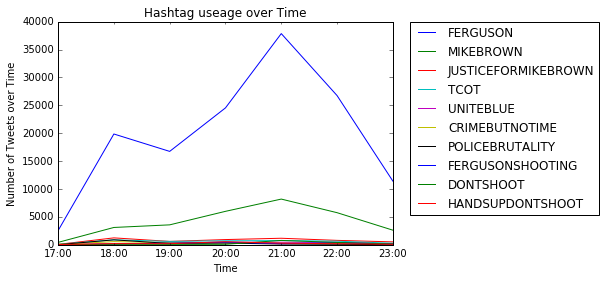

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

for hashtag in popularHashtagsList:
    filteredHashtagTimeCounts = hashtagTimeCounts[hashtagTimeCounts.hashtag == hashtag]
    filteredHashtagTimeCounts.plot(kind = 'line', x = 'createdDatetime', y = 'tweetId', label = hashtag, ax = ax)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('Number of Tweets over Time')
plt.title('Hashtag useage over Time')

Now, we can see the number of times each hashtag was used in a tweet in this dataset. Unfortunately, it appears that the hashtag "Ferguson" was used much more than any of the other hashtags, so this plot is a little hard to read. To adjust for that, let's "normalize" each hashtag line on this graph. To do this, we will divide the number of times that hashtag was used in any given minute by the maxiumum times that hashtag was used in any minute. This will mean that we can see all the lines on the same set of axes. 

/Users/Sophia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


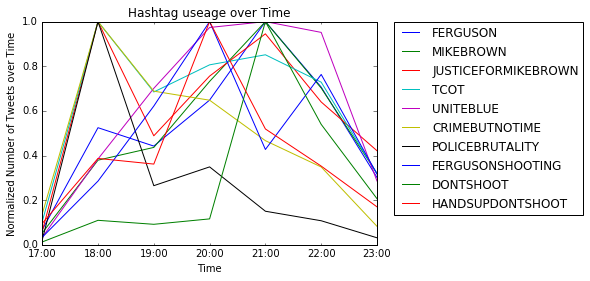

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

for hashtag in popularHashtagsList:
    filteredHashtagTimeCounts = hashtagTimeCounts[hashtagTimeCounts.hashtag == hashtag]
    maxCount = filteredHashtagTimeCounts['tweetId'].max()
    filteredHashtagTimeCounts['normalizedCounts'] = filteredHashtagTimeCounts['tweetId']/maxCount
    filteredHashtagTimeCounts.plot(kind = 'line', x = 'createdDatetime', y = 'normalizedCounts', label = hashtag, ax = ax)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('Normalized Number of Tweets over Time')
plt.title('Hashtag useage over Time')

Hmmm, this isn't the most helpful graph -- it looks like 10 lines is too many but we can  see that a lot of the hashtags follow similar patterns

We can even see where these hashtags are most popular over time!

In [52]:
latLonPopulated_HT = hashtagsDf.dropna(subset=['x','y'])

To make our lives easier, let's declare a vector that has the date bins we want to animate. This will allow us to filter our dataframe intelligently. (by indexing this date_list vector)

In [46]:
startDate = latLonPopulated_HT.createdDatetime.min()
#We've loaded in about 1 day of data
numFrames = 96
date_list = [startDate + timedelta(minutes = 15*x) for x in range(numFrames)]

In [47]:
#Note, the animation code courtesy of and adapted from http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [48]:
def plotAnimationProperly(list_functions, data_to_plot, colors_to_plot):
    for i in range(len(list_functions)):
        list_functions[i].set_data(data_to_plot[i].x,data_to_plot[i].y)
        list_functions[i].set_color(colors_to_plot[i])

In [49]:
import matplotlib.patches as mpatches
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,10))
ax = plt.axes(xlim=(-180, 180), ylim=(-75, 75))
# plt.axis([-180, 180, -75, 75])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
scat, = plt.plot([], [],'o')
scat_top_1, = plt.plot([], [],'o')
scat_top_2, = plt.plot([], [],'o')
scat_top_3, = plt.plot([], [],'o')
scat_top_4, = plt.plot([], [],'o')
scat_top_5, = plt.plot([], [],'o')
scat_top_6, = plt.plot([], [],'o')
scat_top_7, = plt.plot([], [],'o')
scat_top_8, = plt.plot([], [],'o')
scat_top_9, = plt.plot([], [],'o')

# animation function.  This is called sequentially
patches = []
def animate(i):
    subset = []
    color = []
    for j,hashtag in enumerate(popularHashtagsList):
        subset.append(latLonPopulated_HT[
            (latLonPopulated_HT['createdDatetime'] >= date_list[i]) & 
            (latLonPopulated_HT['createdDatetime'] < date_list[i+1]) & 
            (latLonPopulated_HT['hashtag'] == hashtag)])
        color.append(cm.jet(j/float(len(popularHashtagsList))))

    plotAnimationProperly([scat,scat_top_1,scat_top_2,scat_top_3,scat_top_4,scat_top_5,scat_top_6,scat_top_7,scat_top_8,scat_top_9],subset,color)
    
    return scat,scat_top_1,scat_top_2,scat_top_3,scat_top_4,scat_top_5,scat_top_6,scat_top_7,scat_top_8,scat_top_9,

# animation.Animation._repr_html_ = anim_to_html
#set up the legend
for j, hashtag in enumerate(popularHashtagsList):
    patches.append(mpatches.Patch(color=cm.jet(j/float(len(popularHashtagsList))), label=hashtag))
plt.legend(handles=patches, loc='best')

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=numFrames-1, interval=5000, blit=False)

# call our new function to display the animation
display_animation(anim)


We can also plot the hashtags by location! this is currently just a simple scatterplot. 

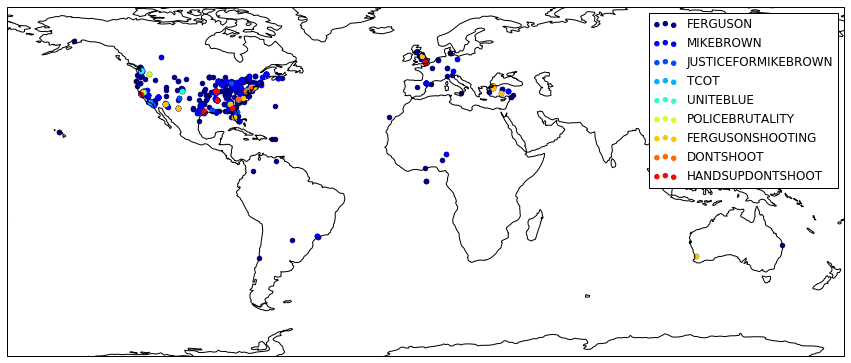

In [54]:
#the cartopy map, going simple outline for now
plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for j,hashtag in enumerate(popularHashtagsList):
    subset = latLonPopulated_HT[(latLonPopulated_HT['hashtag'] == hashtag)]
    if len(subset.x) == 0:
        pass
    else:
        plt.scatter(subset.x,subset.y,color=cm.jet(j/float(len(popularHashtagsList))),label=hashtag)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels, loc='best')
plt.axis([-180, 180, -75, 75])
plt.show()

Although in theory we like this visualization, it's a little hard to tell what hashtags originate where -- there are too many colors. And the points are too much -- let's try doing a heatmap of hashtag distribution. 

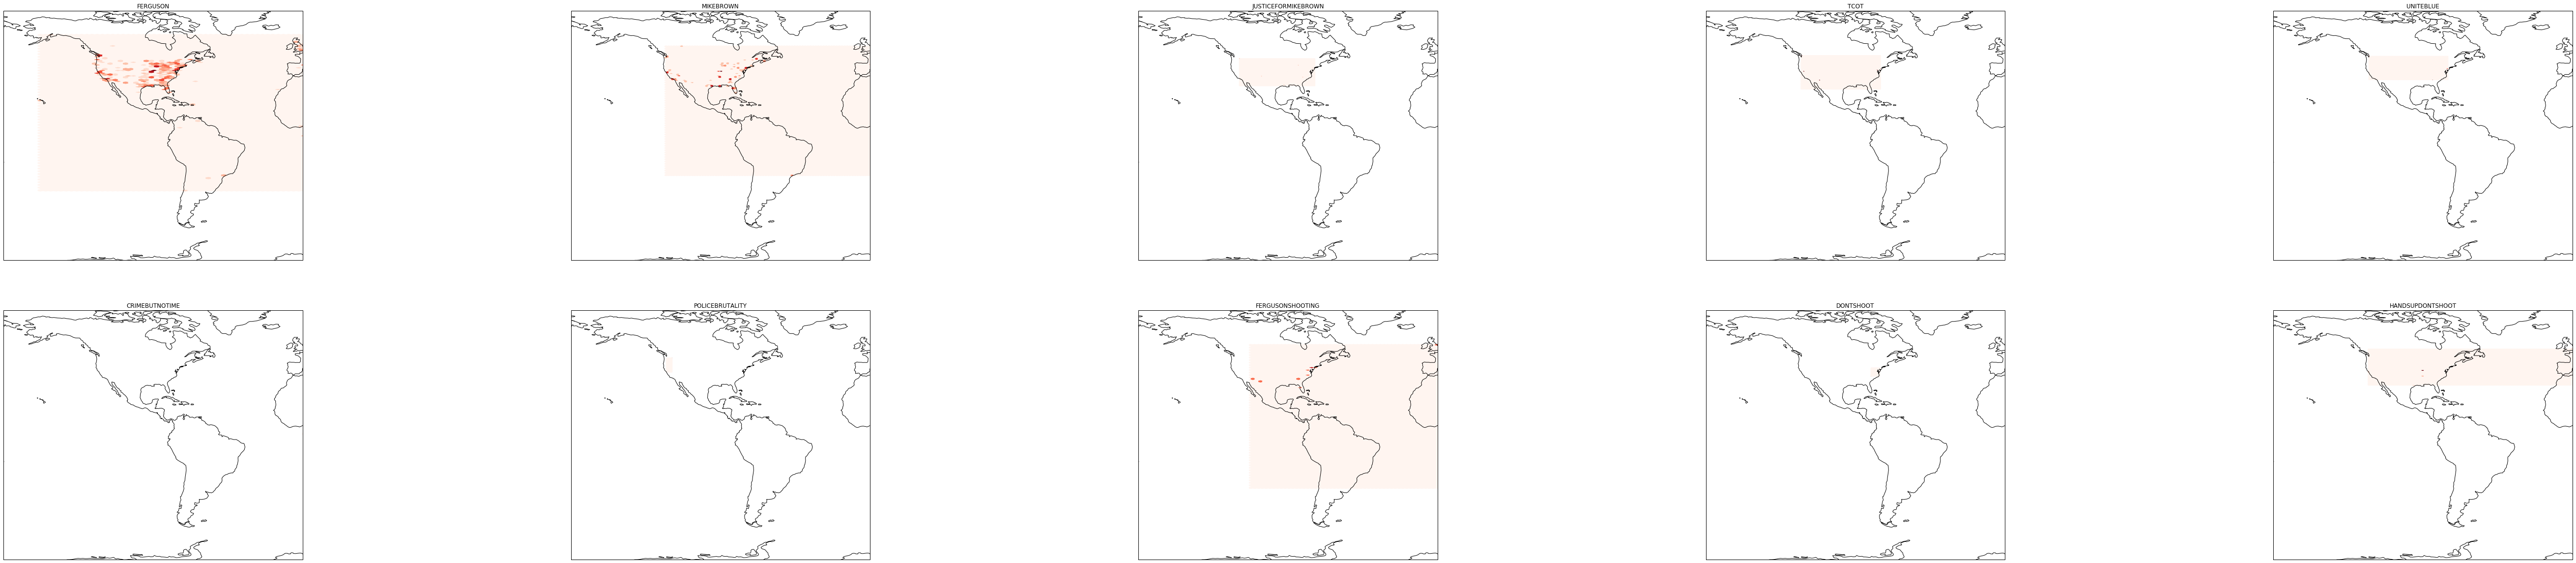

In [58]:
#each hashtag, hexbin
plt.figure(figsize=(100,20))

for j,hashtag in enumerate(popularHashtagsList):
    subset = latLonPopulated_HT[(latLonPopulated_HT['hashtag'] == hashtag)]
    ax = plt.subplot(2,5,j+1,projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.hexbin(subset.x,subset.y,cmap=cm.Reds,bins='log')
    plt.title(hashtag)
    plt.axis([-180, 0, -75, 75])

plt.show()

This makes it much easier to see where certain hashtags are centered! (Note: because we're using a subset of the data, there aren't hashtags that are geo-located for all the top hashtags. 